In [1]:
import os
import IPython.display as ipd
from scipy.io import wavfile
import numpy as np
from scipy import signal
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.decomposition import PCA
import random

In [2]:
# 음성 파일 경로 지정
data_dir = 'C:/Users/nonam/.kaggle/competitions/tensorflow-speech-recognition/'
train_audio_path = data_dir+'train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'

In [3]:
# 음성 파일 읽기
sample_rate, samples = wavfile.read(str(train_audio_path)+filename)
print('sample rate: {}, samples: {}'.format(sample_rate, samples))
# Player 실행
ipd.Audio(samples, rate=sample_rate)

sample rate: 16000, samples: [ 14  -7 -14 ...  19  20  27]


sample_rate: 16,000(초당 16,000개의 음성 파형 데이터를 추출한다는 뜻)

## 스펙트로그램(Spectrogram)

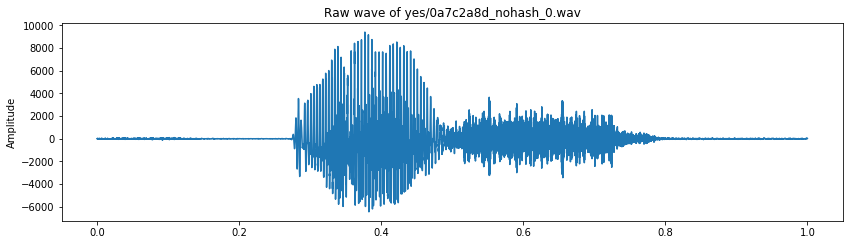

In [4]:
# 음성 파형(sound wave) 시각화
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of '+ filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [5]:
# 스펙트로그램을 계산하는 함수
def specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate,
                                           window='hann',
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           detrend=False)
    
    return freqs, times, spec.T.astype(np.float32)

Text(0.5, 0, 'Seconds')

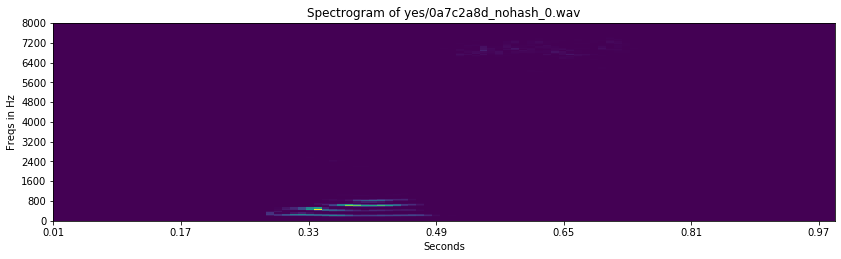

In [6]:
# 스펙트로그램 시각화 
freqs, times, spectrogram = specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax1.set_yticks(freqs[::16]); ax1.set_xticks(times[::16])
ax1.set_title('Spectrogram of ' + filename)
ax1.set_ylabel('Freqs in Hz'); ax1.set_xlabel('Seconds')

음성 파형을 스펙트로그램으로 변환한 시각화. 값의 분포가 적절하지 않아, 일부 영역만 색상이 나타나고 있음

## Log-스펙트로그램 / Mel-스펙트로그램 / MFCC

인간의 목소리를 구별하는데 유의미한 낮음 주파수 영역을 강조하고, 높은 주파수 영역을 상대적으로 덜 강조하도록
log-scale 혹은 mel-scale로 스펙트로그램 값을 조절

In [7]:
# log-스펙트로그램을 계산하는 함수
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio, fs=sample_rate,
                                           window='hann',
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           detrend=False)
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

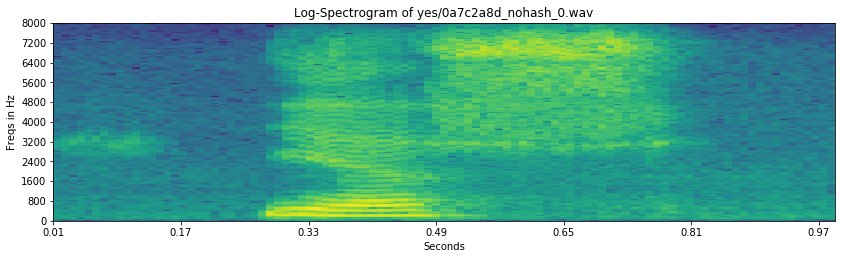

In [8]:
# log-스펙트로그램 시각화 
freqs, times, log_specgram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.imshow(log_specgram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax1.set_yticks(freqs[::16]); ax1.set_xticks(times[::16])
ax1.set_title('Log-Spectrogram of ' + filename)
ax1.set_ylabel('Freqs in Hz'); ax1.set_xlabel('Seconds')

로그 함수로 스케일링한 스펙트로그램 시각화. 각 주파수 영역별로 강조되는 영역이 뚜렷하게 보임

In [9]:
# mel-스펙트로그램을 계산하는 함수
# librosa.melspectrogram()과 로그함수를 씌워 주파수별 값의 분포를 변환.
S = librosa.feature.melspectrogram(samples.astype(np.float16), sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# 시각화
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

ValueError: operands could not be broadcast together with shapes (1,1025) (0,) 

In [10]:
## MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# 시각화
plt.figure(figsize=(12, 4))
librosa.display(specshow(delta2_mfcc))
plt.ylabel('MFCC coeffs'); plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

NameError: name 'log_S' is not defined

음성 인식에서 흔히 사용되는 상위 레벨 변수인 MFCC를 시각화한 그림이다. 기존 스펙트로그램과는 다른 영역이 강조되고 있음을 확인할 수 있다.

## 이상값(FFT -> PCA)

In [11]:
# FFT 변환 함수
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    
    return xf, vals

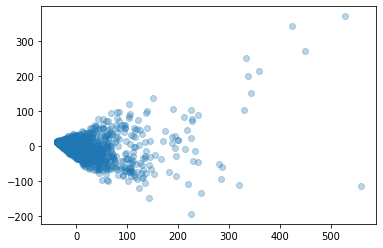

In [12]:
dirs = ['yes','no','up','down','left','right','on','off','stop','go']
fft_all = []
names = []

# FFT 변환
for direct in dirs:
    waves = [f for f in os.listdir('/'.join([train_audio_path, direct])) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path+direct+'/'+wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
            x, val = custom_fft(samples, sample_rate)
            fft_all.append(val)
            names.append(direct+'/'+wav)
            
fft_all = np.array(fft_all)

# 데이터 정규화
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0) # Standardization : (요소값 - 평균) / 표준편차

# PCA를 통해 2차원으로 축소
pca = PCA(n_components=2)
fft_all = pca.fit_transform(fft_all)

# 시각화
plt.scatter(x=fft_all[:,0], y=fft_all[:,1], alpha=0.3)

In [13]:
# x축 성분이 400보다 큰 값을 이상값이라고 가정
for i in np.where(fft_all[:,0] > 400)[0]:
    print(names[i])

yes/03cf93b1_nohash_0.wav
stop/03cf93b1_nohash_0.wav
stop/7cb5c0b7_nohash_0.wav
stop/facd97c0_nohash_0.wav


## Data Augmentation
- background_noise의 소음을 랜덤하게 추가
- 음성의 위치를 랜덤하게 이동
- 파형의 높이를 변형

In [20]:
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

# 음성 위치를 200ms~800ms 사이의 값으로 랜덤하게 이동
shift_range = random.randint(200, 800)
shift = sample_rate * 100 // 1000
shift = random.randint(-shift, shift)
a = -min(0, shift)
b = max(0, shift)
sample_aug = np.pad(samples, (a,b),'constant').astype(np.float16)
sample_aug = sample_aug[:len(sample_aug) - a] if a else sample_aug[b:]

# 제공된 배경 소음 중, 랜덤으로 1초 가량의 소음을 추가
max_ratio = random.choice([0.1, 0.5, 1, 1.5])
noise_filenames = [f for f in os.listdir('/'.join([train_audio_path, '_background_noise_'])) if f.endswith('.wav')]
noise_filename = noise_filenames[random.randint(0, len(noise_filenames)-1)]
_, noise_samples = wavfile.read(str(train_audio_path)+'_background_noise_/'+noise_filename)
start_idx = random.randint(0, len(noise_samples)-1-sample_rate)
noise_samples = noise_samples[start_idx:(start_idx+sample_rate)]
max_ratio = random.choice([0.1, 0.5, 1, 1.5])
sample_aug += max_ratio * random.random() * noise_samples.astype(np.float16)

# 파형의 높이를 스케일링
scale = random.uniform(0.75, 1.25)
sample_aug *= scale

# Audio
ipd.Audio(sample_aug, rate=sample_rate)

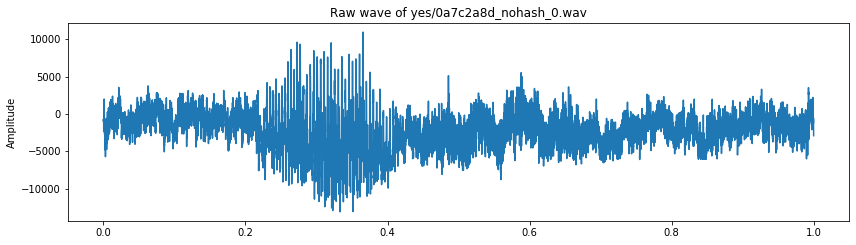

In [21]:
# 가공한 음성 파형(sound wave) 시각화
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of '+ filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(sample_aug), sample_rate), sample_aug)